In [3]:
import os
import pandas as pd
import sqlalchemy
import sklearn
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

connection_string = os.getenv("LINODE_CONN_STRING")
connection_string = os.getenv("LINODE_CONN_STRING")
conn = sqlalchemy.create_engine(os.getenv("LINODE_CONN_STRING")).connect()

In [4]:
data = pd.read_sql("select * from sports_data.tourney_games_with_season_stats", conn)

In [5]:
data

,date,team,opponent,season,location,Win_Loss,score,opponent_score,adj_offense_team,adj_defense_team,...,offensive_efficiency_opponent,effective_fg_percent_opponent,turnover_percent_opponent,offensive_rebound_percent_opponent,free_throw_rate_opponent,opponent_offensive_efficiency_opponent,opponent_effective_fg_percent_opponent,opponent_turnover_percent_opponent,opponent_offensive_rebound_percent_opponent,opponent_free_throw_rate_opponent
0,3/17/23,Arizona St.,TCU,2023,N,L,70,72,105.770588,93.755882,...,105.500000,50.354545,17.106061,32.269697,34.730303,95.600000,48.115152,21.963636,30.745455,30.539394
1,3/17/23,TCU,Arizona St.,2023,N,W,72,70,110.433333,92.660606,...,100.982353,48.141176,16.873529,29.317647,31.976471,96.970588,46.679412,20.541176,31.555882,34.017647
2,3/23/23,Arkansas,Connecticut,2023,N,L,65,88,110.545455,91.821212,...,114.263636,53.454545,18.872727,39.148485,32.106061,95.096970,45.481818,19.206061,26.109091,38.945455
3,3/23/23,Connecticut,Arkansas,2023,N,W,88,65,118.684848,92.387879,...,105.769697,52.209091,18.424242,30.518182,39.145455,95.842424,46.693939,20.284848,28.193939,39.651515
4,3/18/23,Arkansas,Kansas,2023,N,W,72,71,110.545455,91.821212,...,106.100000,52.400000,17.526471,28.476471,30.547059,96.370588,47.261765,20.200000,28.105882,31.544118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237,3/19/15,Wofford,Arkansas,2015,N,L,53,56,102.521875,97.062500,...,109.882353,50.252941,16.623529,34.920588,37.932353,99.297059,48.608824,22.458824,34.135294,39.347059
1238,3/20/15,Northern Iowa,Wyoming,2015,N,W,71,54,114.212121,92.445455,...,103.184375,52.331250,18.668750,22.412500,42.184375,95.321875,46.840625,17.990625,26.915625,26.956250
1239,3/20/15,Wyoming,Northern Iowa,2015,N,L,54,71,102.778125,97.556250,...,112.487879,56.930303,17.900000,25.669697,41.096970,92.696970,45.075758,19.327273,25.645455,26.939394
1240,3/26/15,Arizona,Xavier,2015,N,W,68,60,115.205882,86.835294,...,109.329412,53.417647,18.117647,31.182353,39.494118,100.508824,50.320588,19.258824,26.823529,35.208824


In [7]:
data['Win_Loss_Flag'] = data['Win_Loss'].apply(lambda x: 1 if x == 'W' else 0)

In [13]:
predictor_columns = data.columns[8:-1]
predictors = data[predictor_columns]
predictors_and_response = pd.concat([predictors, data['Win_Loss_Flag']], axis=1)

In [16]:
predictors_and_response.corr()['Win_Loss_Flag'].sort_values(ascending=False)

Win_Loss_Flag                                  1.000000
adj_offense_team                               0.270970
adj_defense_opponent                           0.225174
offensive_efficiency_team                      0.196490
opponent_offensive_efficiency_opponent         0.123610
effective_fg_percent_team                      0.116454
opponent_effective_fg_percent_opponent         0.112050
turnover_percent_opponent                      0.106504
offensive_rebound_percent_team                 0.104910
opponent_free_throw_rate_opponent              0.070684
free_throw_rate_opponent                       0.066086
opponent_turnover_percent_team                 0.033527
opponent_offensive_rebound_percent_opponent    0.001040
opponent_offensive_rebound_percent_team       -0.001040
opponent_turnover_percent_opponent            -0.033527
free_throw_rate_team                          -0.066086
opponent_free_throw_rate_team                 -0.070684
offensive_rebound_percent_opponent            -0

In [18]:
corrs = predictors_and_response.corr()['Win_Loss_Flag']
corrs = corrs[corrs > 0.02]
corrs = corrs[corrs.index != 'Win_Loss_Flag']
effective_predictors = corrs.index

In [19]:
len(effective_predictors)

11

In [21]:
prediction_data = data[effective_predictors]
prediction_data_normalized = (prediction_data-prediction_data.mean())/prediction_data.std()

In [22]:
prediction_data_normalized

,adj_offense_team,offensive_efficiency_team,effective_fg_percent_team,offensive_rebound_percent_team,opponent_turnover_percent_team,adj_defense_opponent,turnover_percent_opponent,free_throw_rate_opponent,opponent_offensive_efficiency_opponent,opponent_effective_fg_percent_opponent,opponent_free_throw_rate_opponent
0,-0.927835,-1.624681,-1.649647,-0.387095,0.617680,-0.591715,-0.114575,-0.058197,-0.464621,0.068223,-0.223741
1,-0.212381,-0.766889,-0.859129,0.315748,1.201215,-0.385921,-0.239694,-0.604433,-0.172103,-0.505183,0.359243
2,-0.195177,-0.715680,-0.196766,-0.101264,0.512527,-0.642958,0.836021,-0.578729,-0.571980,-0.983478,1.185184
3,1.053736,0.897114,0.248055,1.953495,0.069976,-0.749431,0.594703,0.817571,-0.412882,-0.499381,1.303525
4,-0.195177,-0.715680,-0.196766,-0.101264,0.512527,-0.790995,0.111636,-0.887965,-0.300158,-0.272603,-0.055341
...,...,...,...,...,...,...,...,...,...,...,...
1237,-1.426319,-0.604308,-0.281490,-0.531916,0.416185,0.157309,-0.374213,0.576946,0.324425,0.265386,1.252496
1238,0.367438,0.559941,1.489443,-1.255623,0.119701,0.328140,0.726266,1.420357,-0.523980,-0.440797,-0.824305
1239,-1.387000,-1.206570,-0.153137,-2.031117,-0.428632,-0.632140,0.312622,1.204664,-1.084201,-1.145650,-0.827130
1240,0.519922,0.775015,0.189707,0.712305,0.844513,0.025232,0.429733,0.886730,0.583046,0.949030,0.558894


In [23]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(prediction_data_normalized, data['Win_Loss_Flag'])

In [25]:
data['predicted_outcome'] = clf.predict(prediction_data_normalized)

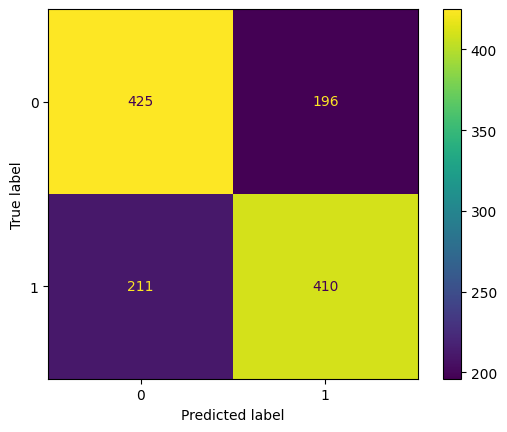

In [30]:
sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(data['Win_Loss_Flag'], data['predicted_outcome'])).plot()

Logistic regression predicted 835 games correctly and got 407 wrong. Getting about 2/3 of the games right is not bad, but it's not great either. Other models might yield better results.